# Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
!pip install imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 48.2 MB/s eta 0:00:0000:0100:01


In [2]:
import os, sys
import tensorflow as tf
import wandb
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
if not os.path.exists('tiny_nerf_data.npz'): 
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz --no-check-certificate

--2024-04-28 15:03:28--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-04-28 15:03:28--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  7.67MB/s    in 1.6s    

2024-04-28 15:03:30 (7.67 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


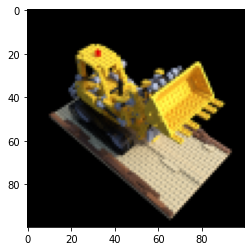

In [5]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [6]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [10]:
model = init_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          10240       input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          65792       dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          65792       dense_10[0][0]                   
____________________________________________________________________________________________

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

In [11]:
wandb.init(
    # set the wandb project where this run will be logged
    project="NeRF",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0005,
    "architecture": "NeRF",
    "dataset": "Lego",
    "epochs": 1000,
    }
)

LOSS,█▁▁
PSNR,▁▇█
LOSS,0.08053
PSNR,10.94026


0 0.012097454071044922 secs per iter


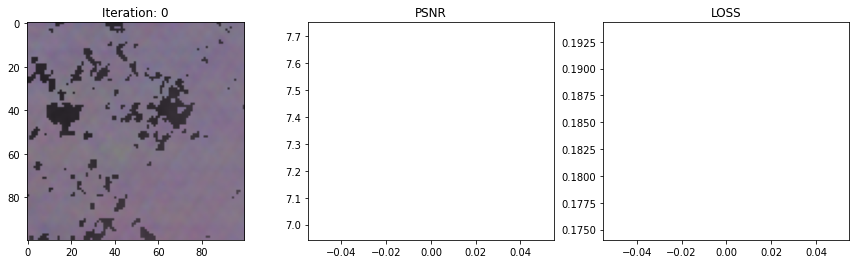

20 0.47505271434783936 secs per iter


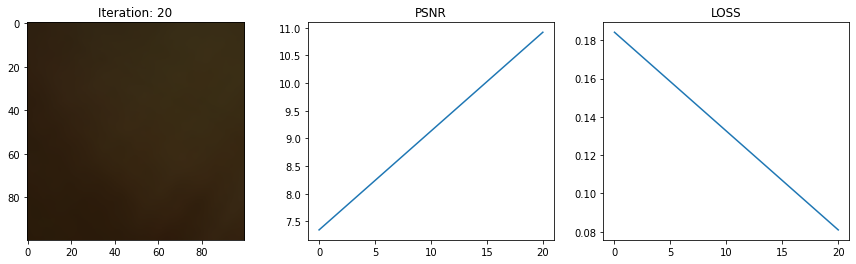

40 0.47268240451812743 secs per iter


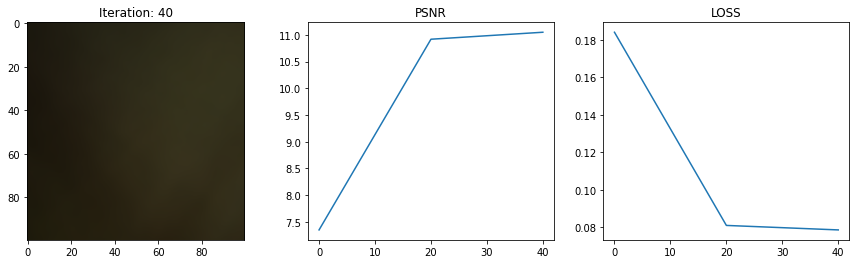

60 0.4720309257507324 secs per iter


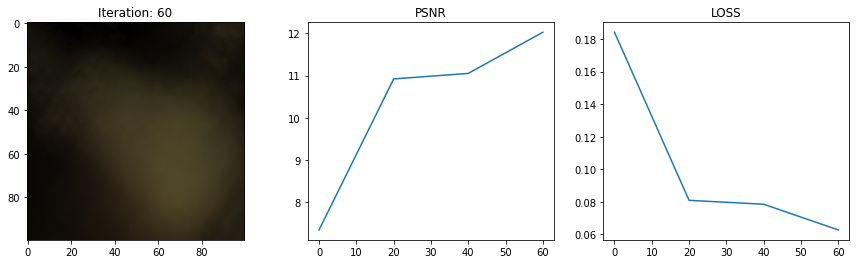

80 0.4737184762954712 secs per iter


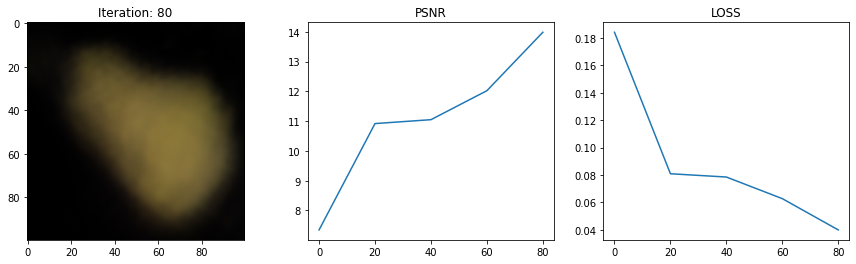

100 0.46951497793197633 secs per iter


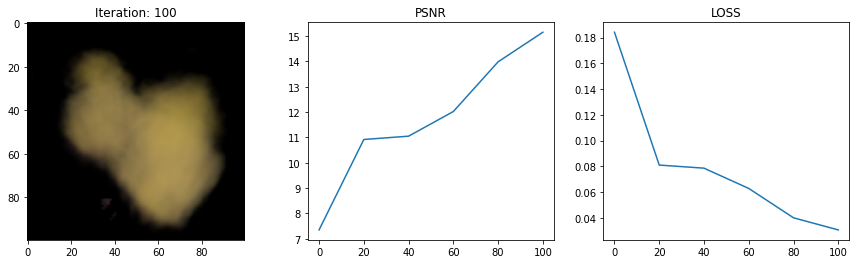

120 0.47069334983825684 secs per iter


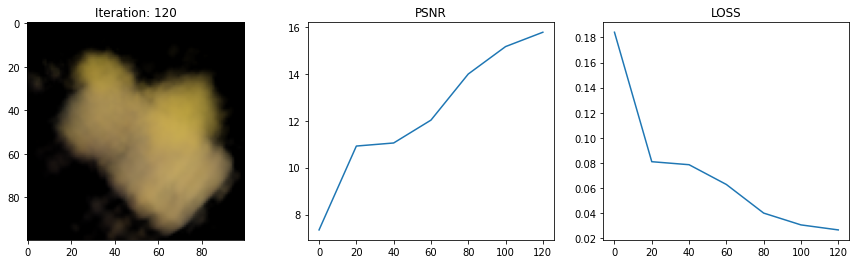

140 0.4706334114074707 secs per iter


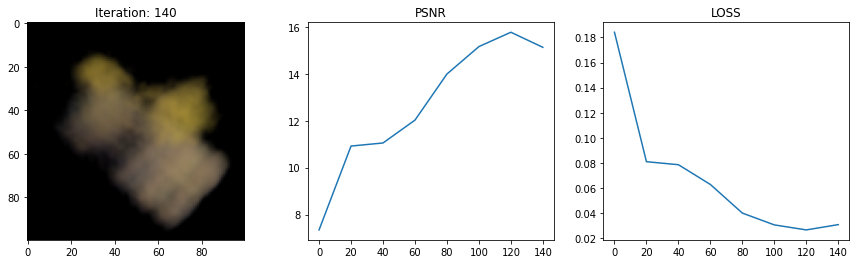

160 0.47294228076934813 secs per iter


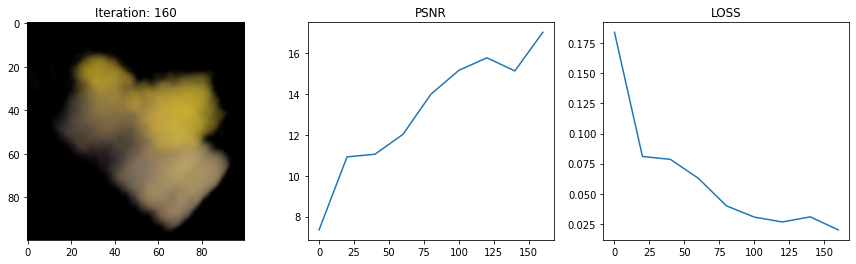

180 0.4697062611579895 secs per iter


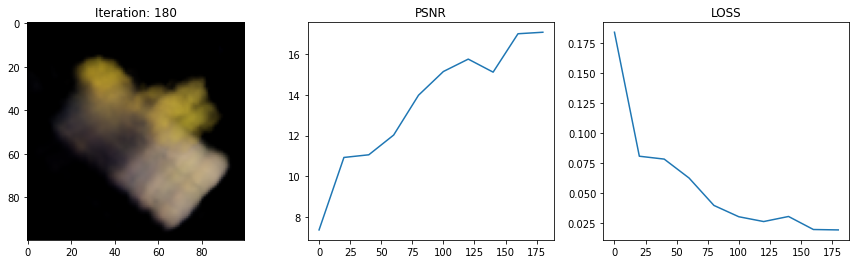

200 0.48384019136428835 secs per iter


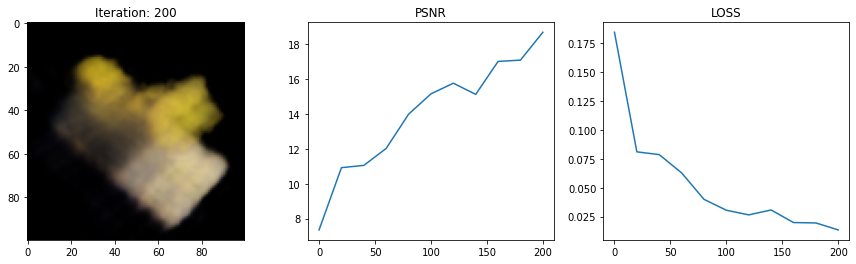

220 0.47480777502059934 secs per iter


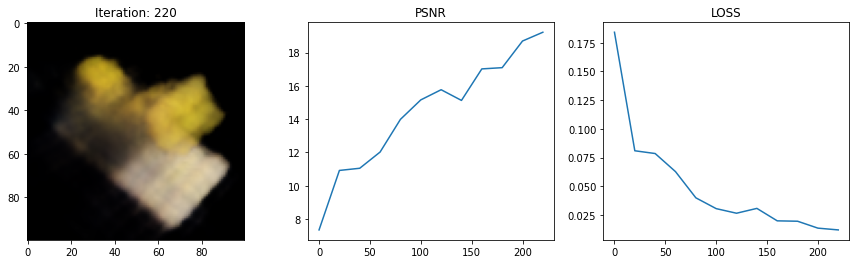

240 0.47218135595321653 secs per iter


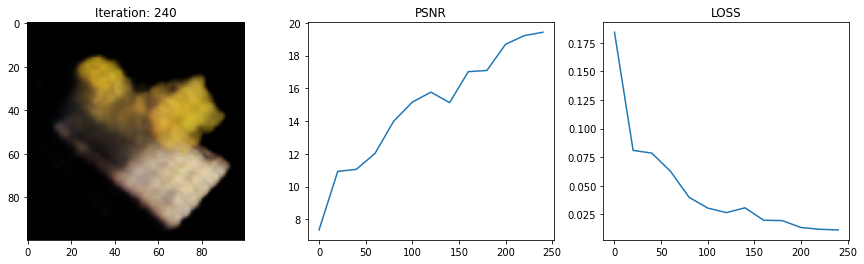

260 0.47459834814071655 secs per iter


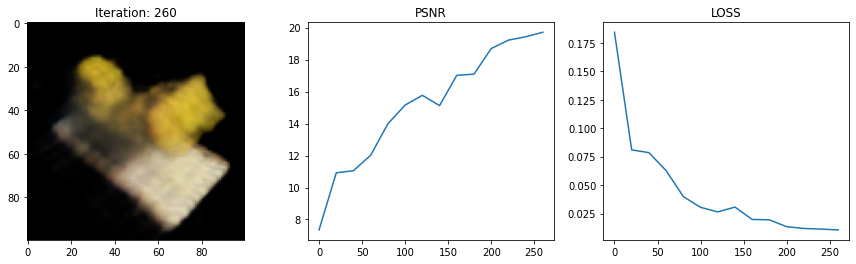

280 0.474701464176178 secs per iter


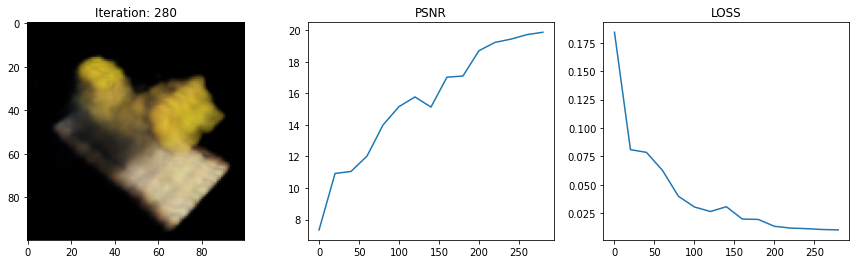

300 0.4751474499702454 secs per iter


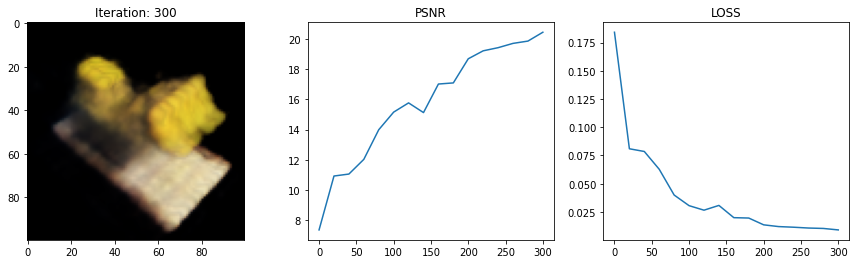

320 0.4736183166503906 secs per iter


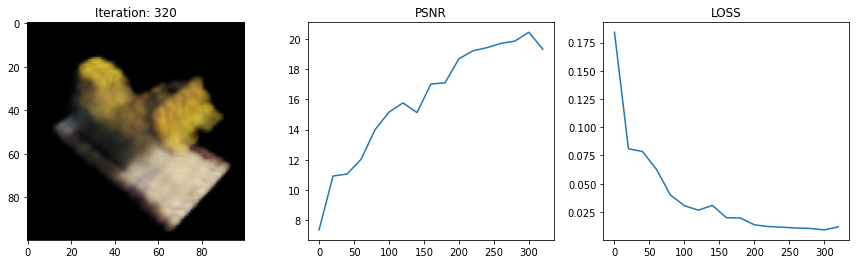

340 0.47089486122131347 secs per iter


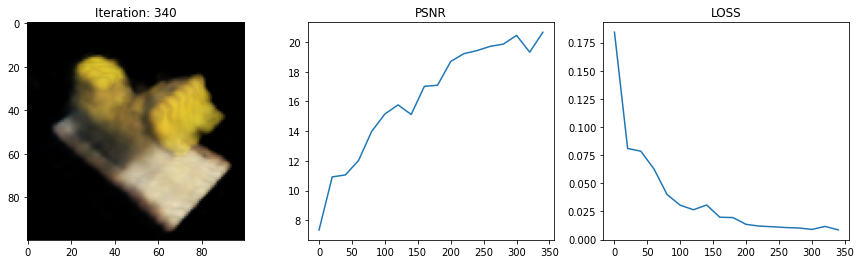

360 0.47509872913360596 secs per iter


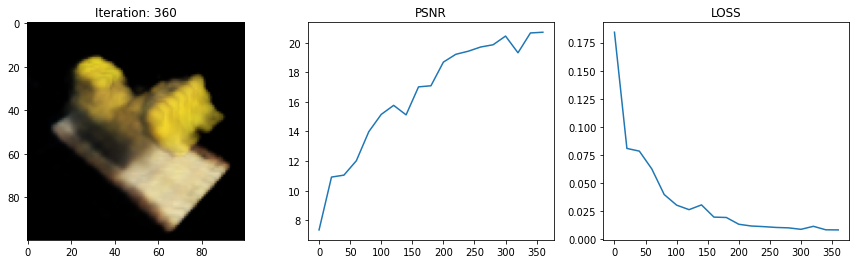

380 0.4707000494003296 secs per iter


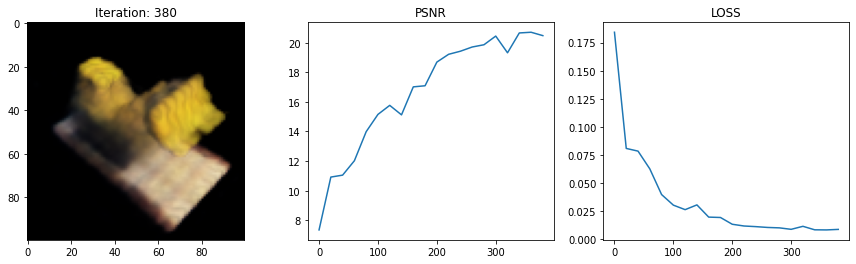

400 0.4828222393989563 secs per iter


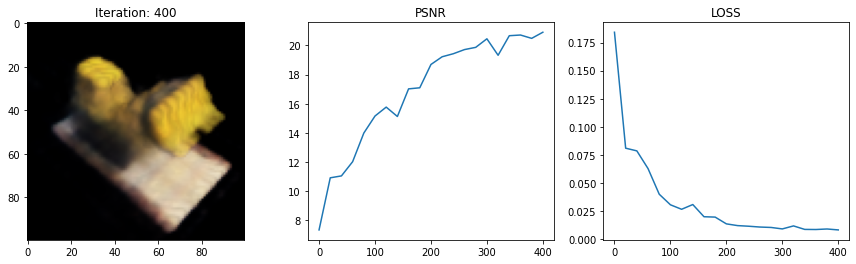

420 0.47486315965652465 secs per iter


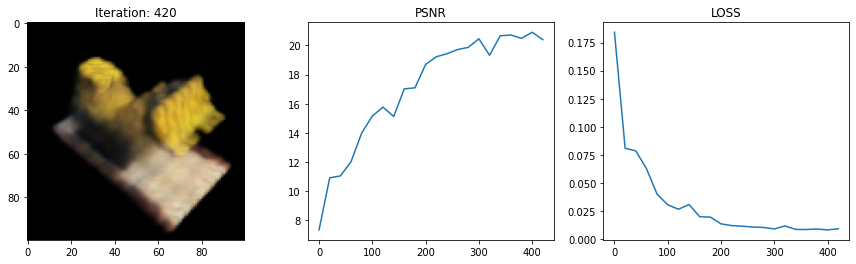

440 0.4704382300376892 secs per iter


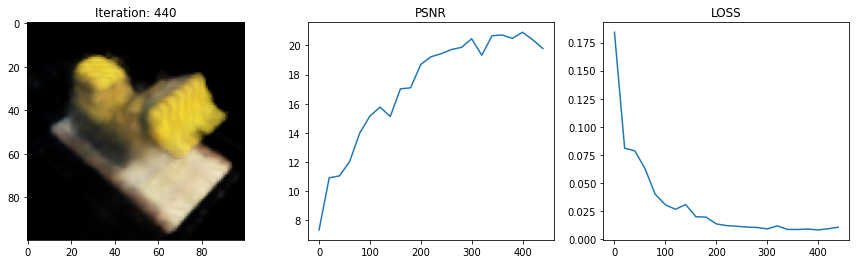

460 0.47488396167755126 secs per iter


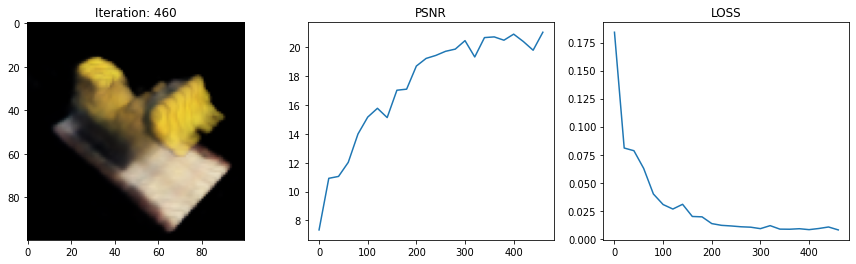

480 0.47078847885131836 secs per iter


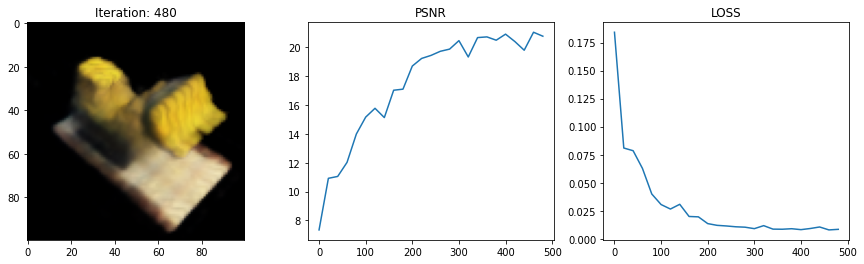

500 0.4750470995903015 secs per iter


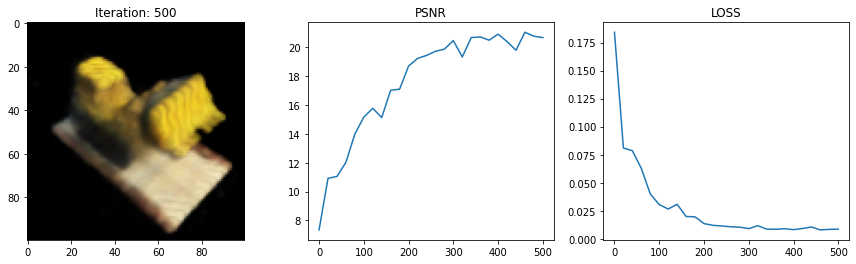

520 0.471735680103302 secs per iter


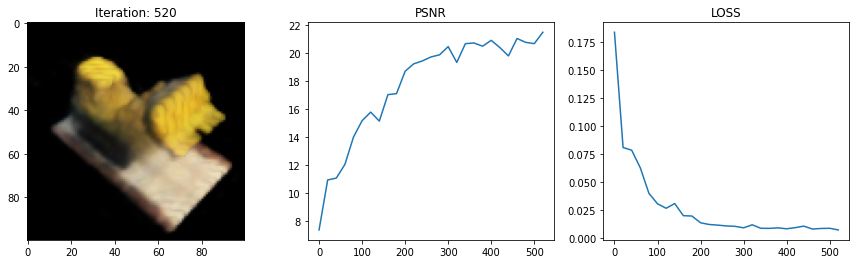

540 0.4714066028594971 secs per iter


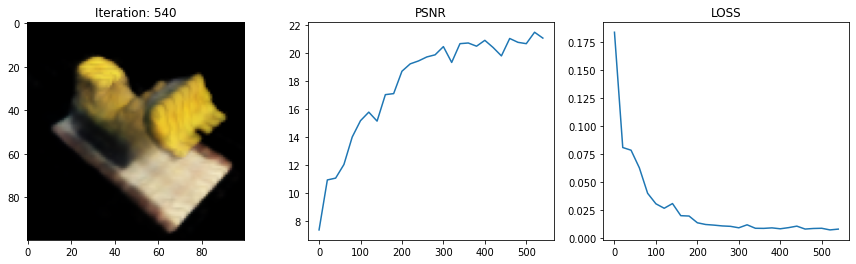

560 0.4742331027984619 secs per iter


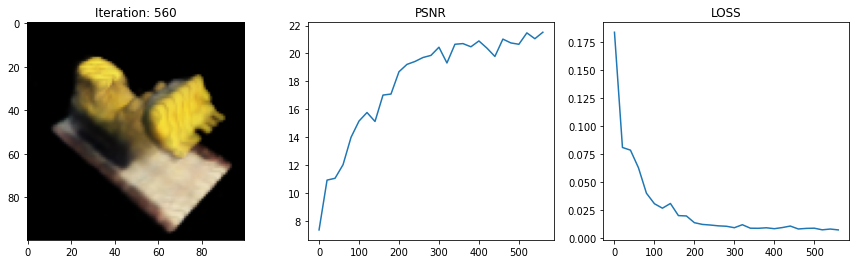

580 0.47078350782394407 secs per iter


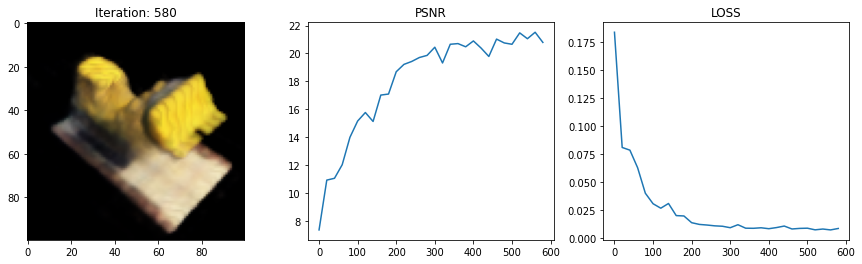

600 0.47426782846450805 secs per iter


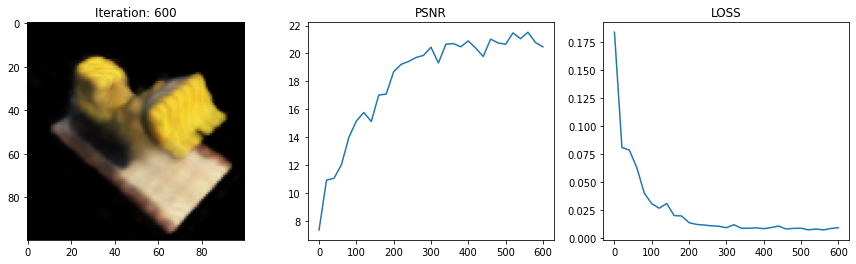

620 0.486133873462677 secs per iter


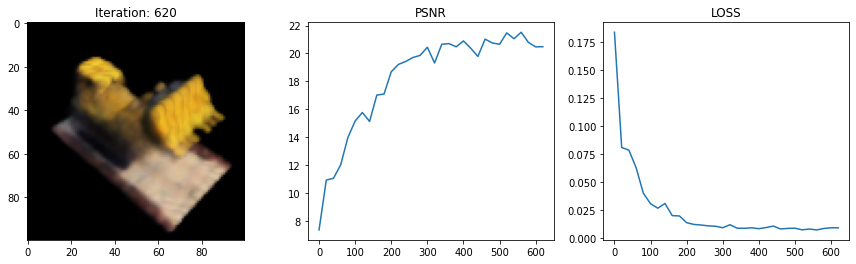

640 0.47425941228866575 secs per iter


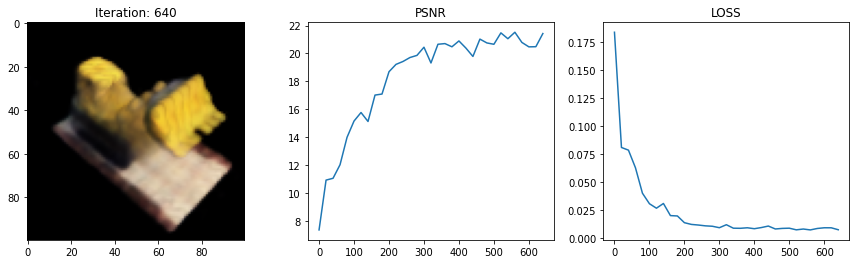

660 0.47004185914993285 secs per iter


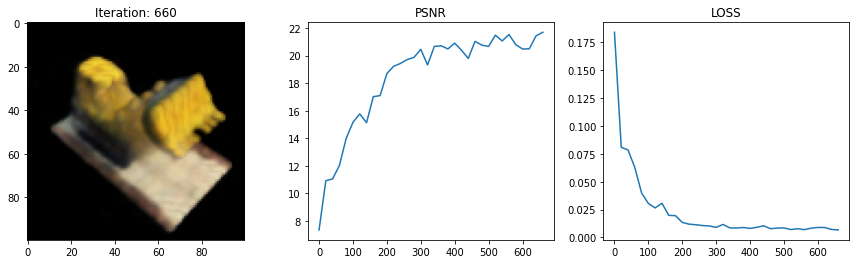

680 0.4715619206428528 secs per iter


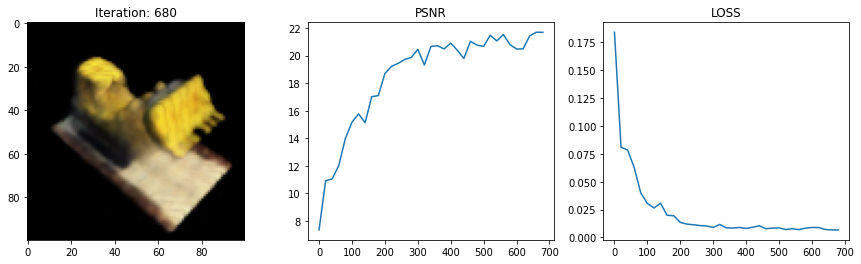

700 0.47044734954833983 secs per iter


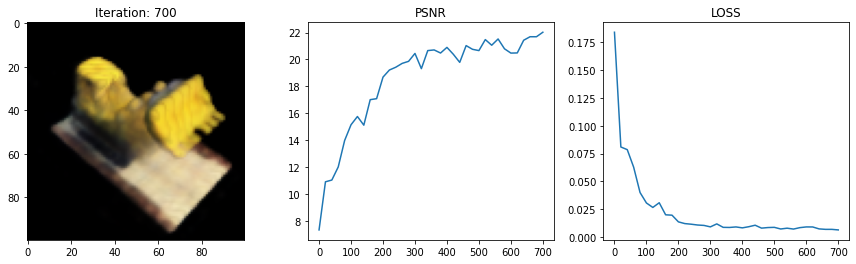

720 0.4738198757171631 secs per iter


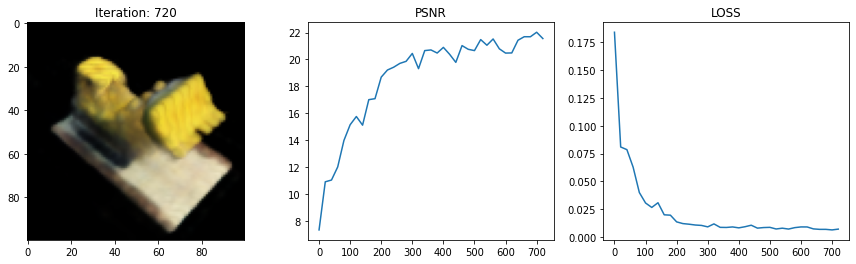

740 0.47451484203338623 secs per iter


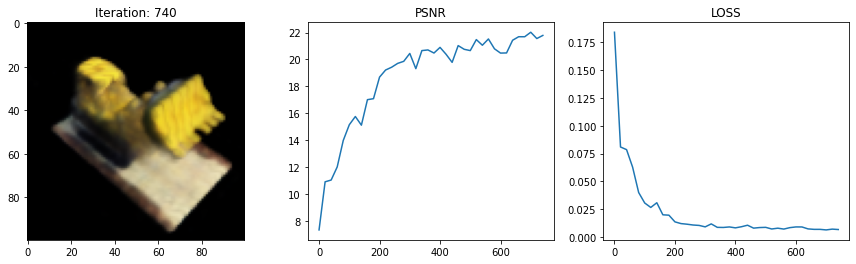

760 0.4725224494934082 secs per iter


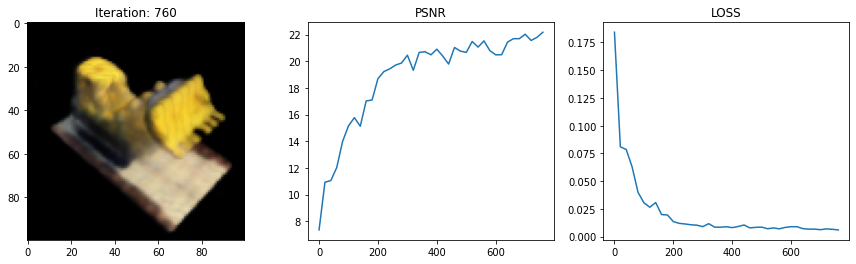

780 0.4730088472366333 secs per iter


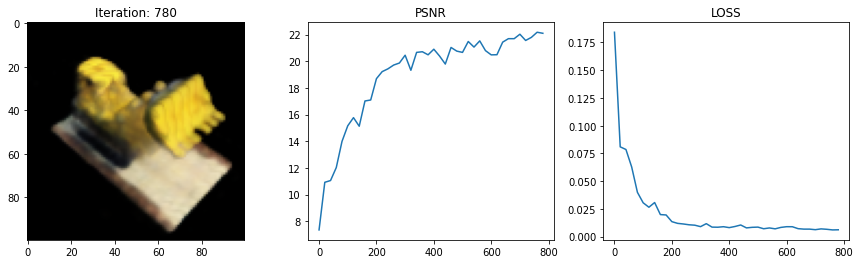

800 0.470845103263855 secs per iter


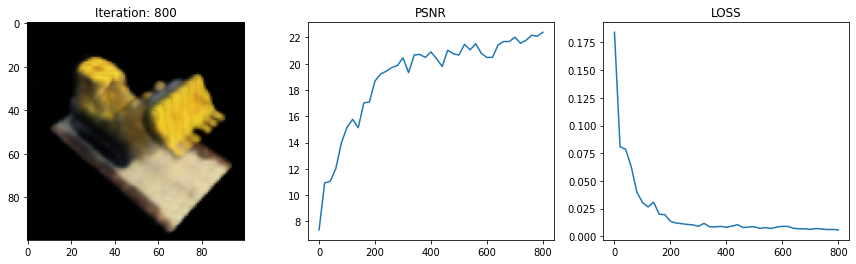

820 0.48577587604522704 secs per iter


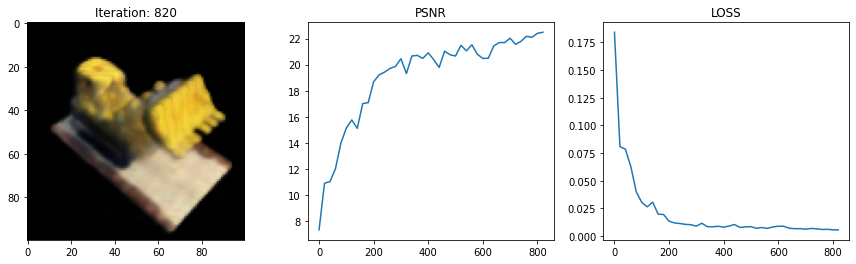

840 0.47391983270645144 secs per iter


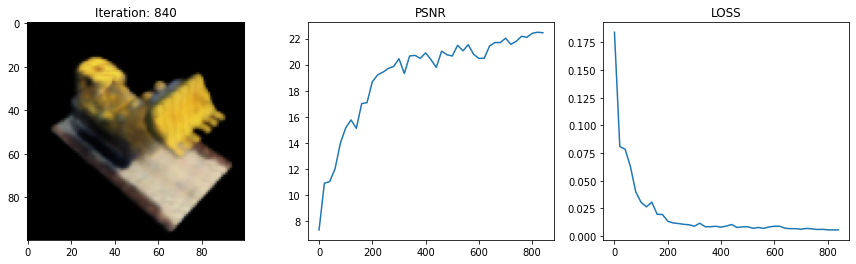

860 0.47272696495056155 secs per iter


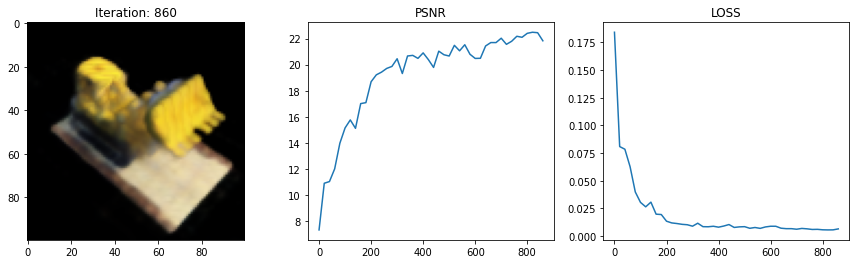

880 0.4729770183563232 secs per iter


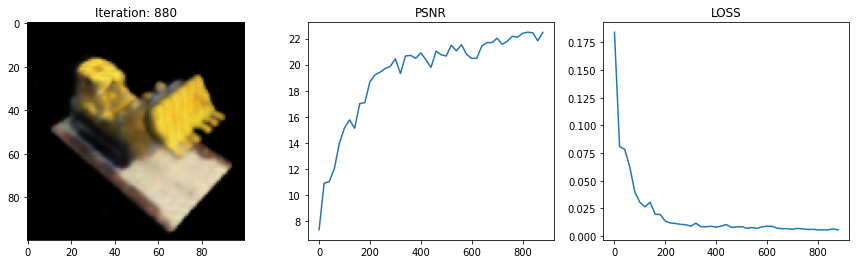

900 0.473573362827301 secs per iter


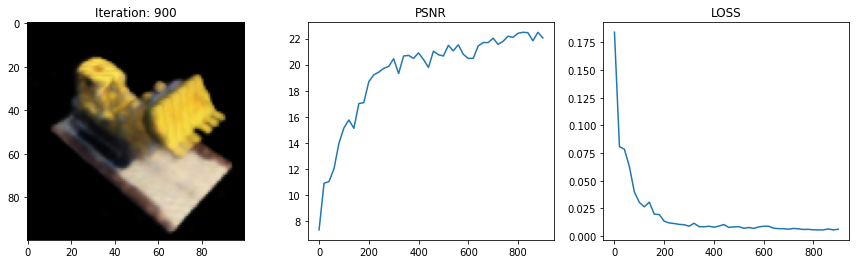

920 0.4732836842536926 secs per iter


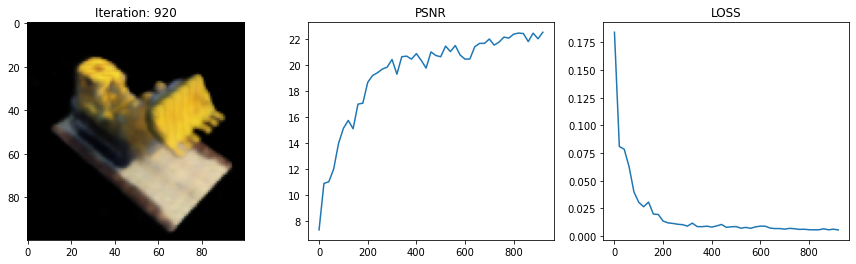

940 0.4742509126663208 secs per iter


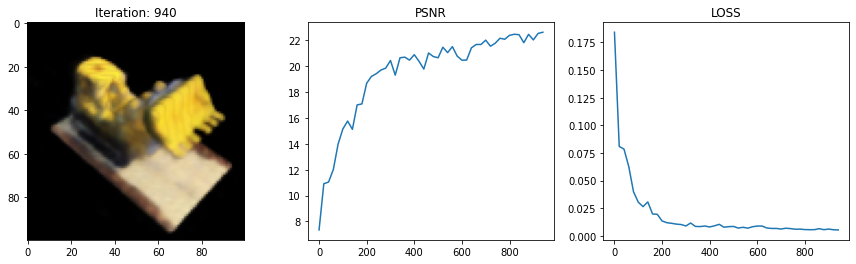

960 0.4734048962593079 secs per iter


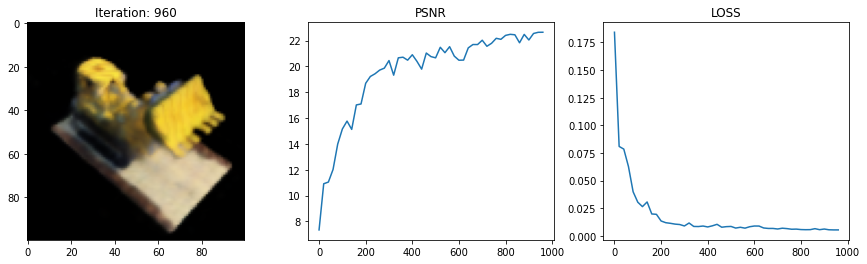

980 0.4741184115409851 secs per iter


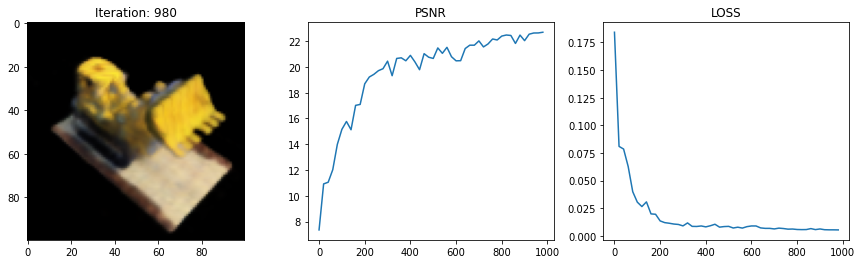

1000 0.4736102223396301 secs per iter


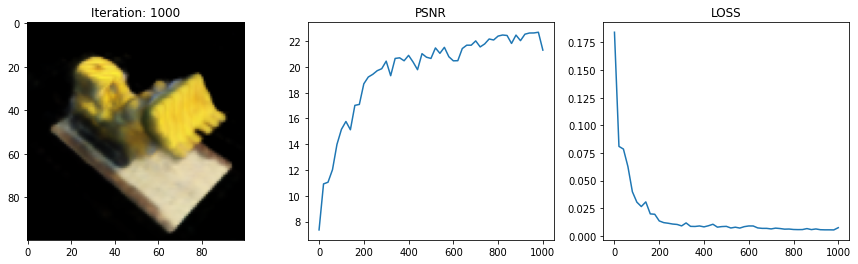

Done


In [12]:

optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 20
losses = []

images_log = []

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    
    
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        
        wandb.log({"PSNR": psnr, "LOSS": loss})
        
        images_log.append(rgb)
        psnrs.append(psnr.numpy())
        losses.append(loss.numpy())
        iternums.append(i)
        plt.figure(figsize=(15,4))
        plt.subplot(131)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(132)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.subplot(133)
        plt.plot(iternums, losses)
        plt.title('LOSS')
        plt.show()

print('Done')

In [16]:
!pip install moviepy imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 9.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=38c36342e0c53f0c643a4524c1a91c7c16c1d6d209bd661d57d6a5e9d5836b8c
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2022.2.0 requires fsspec==2022.02.0, but you have fsspec 2022.3.0 which is incompatible.


In [16]:
import imageio
images_log = np.array(images_log)
imageio.mimwrite("NeRF Reconstruction.mp4", images_log, fps=7, quality=7)

[swscaler @ 0x5fb23c0] Warning: data is not aligned! This can lead to a speed loss


# Interactive Visualization

In [17]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [18]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

[swscaler @ 0x71353c0] Warning: data is not aligned! This can lead to a speed loss


In [19]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

wandb: Network error (ReadTimeout), entering retry loop.
